Value at risk


Def: potential for loss i and the probability that the defined loss will occur. 

One measures VaR by assessing the amount of potential loss, the probability of occurrence for the amount of loss, and the time frame.

e.g. Daily VaR 95% with 1 year lookback period （refer to 1 year market data）is 1 million USD
     within 95% of the time the loss of the portfolio is lower or equal to 1 million USD. 


3 Methods:
1.  Historical Method: 
    The historical method looks at one’s prior returns history 
    and orders them from worst losses to greatest gains
    Assumption: following from the premise that past returns experience will inform future outcomes. 

2. Parametric VaR Method
   Assumes that gains and losses are normally distributed. 
   This way, potential losses can be framed in terms of standard deviation events from the mean.
   The variance-covariance method works best for risk measurement in which the distributions are known and reliably estimated. 

3. Monte Carlo Method
   A third approach to VaR is to conduct a Monte Carlo simulation. 
   This technique uses computational models to simulate projected returns over hundreds or thousands of possible iterations. 
   Then, it takes the chances that a loss will occur—say, 5% of the time—and reveals the impact.

Step 1: import libraries

In [276]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns 

Step 2: get raw data, use 3 stocks as example with equal weight, below is for calculate the percentage VaR

In [310]:
def importdata(tickers,start="2020-01-01",end="2022-01-31"):
    data = yf.download(tickers, 
                       start = start, end = end, 
                       progress= False)['Adj Close']
    return(data)

###Example: 
data = importdata(["MSFT","AAPL","GOOG"])
data

,AAPL,GOOG,MSFT
Date,,,
2020-01-02,73.152649,68.368500,154.779510
2020-01-03,72.441460,68.032997,152.852249
2020-01-06,73.018692,69.710503,153.247345
2020-01-07,72.675278,69.667000,151.850067
2020-01-08,73.844360,70.216003,154.268814
...,...,...,...
2022-01-24,159.794235,130.371994,291.038147
2022-01-25,157.975037,126.735497,283.299896
2022-01-26,157.886047,129.240005,291.372040


In [280]:
pctrtn = data.pct_change().dropna()
pctrtn.head()

,AAPL,GOOG,MSFT
Date,,,
2020-01-03,-0.009722,-0.004907,-0.012452
2020-01-06,0.007968,0.024657,0.002585
2020-01-07,-0.004703,-0.000624,-0.009118
2020-01-08,0.016086,0.007880,0.015928
2020-01-09,0.021241,0.011044,0.012493


In [330]:
weight = [1/3,1/3,1/3]
histrtn = (weight * pctrtn)
histrtn['Total'] = histrtn.sum(axis=1)
histrtn.head()

,AAPL,GOOG,MSFT,Total
Date,,,,
2020-01-03,-0.003241,-0.001636,-0.004151,-0.009027
2020-01-06,0.002656,0.008219,0.000862,0.011737
2020-01-07,-0.001568,-0.000208,-0.003039,-0.004815
2020-01-08,0.005362,0.002627,0.005309,0.013298
2020-01-09,0.007080,0.003681,0.004164,0.014926


Method 1: Historical 1D 95% VaR based on 1 year historical data

In [399]:
def histvar(stktck,weight,startdate,enddate,confidenceinterval = 95):
    data = importdata(stktck)
    pctrtn = data.pct_change().dropna()
    histrtn = (weight * pctrtn)
    histrtn['Total'] = histrtn.sum(axis=1)
    sns.histplot(histrtn['Total'],stat = "probability",kde=True)
    historic_var = abs(np.percentile(histrtn['Total'], 100 - confidenceinterval, method="lower"))
    result = "The simple historical " + str(confidenceinterval) + "% VaR is " + "{:.1%}".format(historic_var)
    return(result)

'The simple historical 95% VaR is 2.8%'

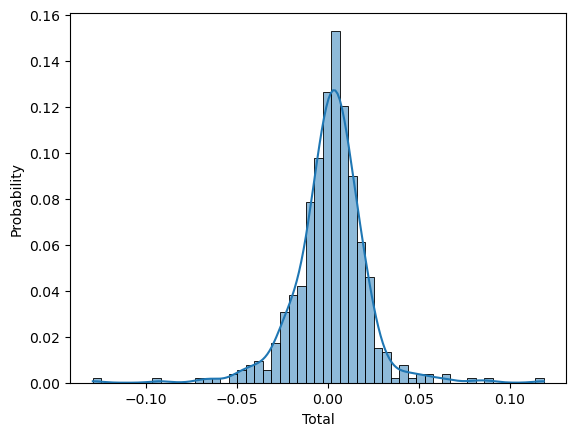

In [400]:
stktck = ["MSFT","AAPL","GOOG"]
weight = [1/3,1/3,1/3]
startdate = "2020-01-01"
enddate="2022-01-31"
histvar(stktck,weight,startdate,enddate)

Method 2: Parametric VaR

In [334]:
def parametricvar(stktck,weight,startdate,enddate,confidenceinterval = 95):
    data = importdata(stktck)
    pctrtn = data.pct_change().dropna()
    histrtn = (weight * pctrtn)
    histrtn['Total'] = histrtn.sum(axis=1)
    mu = histrtn['Total'].mean()
    sigma = histrtn['Total'].std()

    # Plot the histogram. 
    plt.hist(histrtn['Total'], bins=50, density=True, alpha=0.6, color='b') 
  
    # Plot the PDF. 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, sigma) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    plt.show() 
    #plt.plot(histrtn['Total'], norm.pdf(norm.pdf(histrtn['Total'], mu, sigma)))
    Z = norm.ppf(confidenceinterval/100)
    parametric_VaR = abs(mu - Z * sigma)
    result = 'The parametric ' +str(confidenceinterval) + '% VaR is ' + "{:.1%}".format(parametric_VaR)
    return(result)

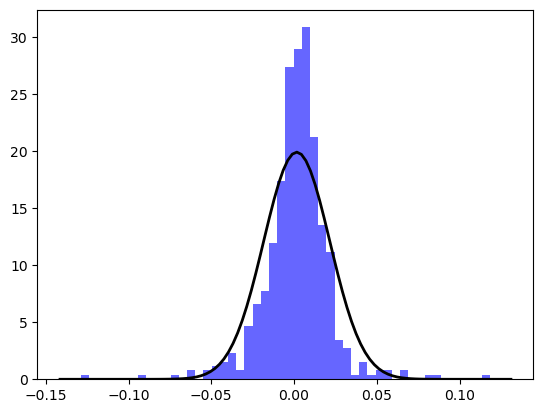

'The parametric 95% VaR is 3.1%'

In [335]:
stktck = ["MSFT","AAPL","GOOG"]
weight = [1/3,1/3,1/3]
startdate = "2020-01-01"
enddate="2022-01-31"
parametricvar(stktck,weight,startdate,enddate)

Method 3: 1 day 95% MonteCarlo VaR (for comparable purpose)
, normally would size 1 day into few steps for more accurate result

In [401]:
def mcvar(data,days,iterations,confidenceinterval = 5):
    logreturn = np.log(1 + data.pct_change().dropna())
    drift = logreturn.mean() - 0.5*(logreturn.std())**2
    sigma = logreturn.std()
    daily_rtn =np.exp(drift + sigma * norm.ppf(np.random.rand(days, iterations)))
    mcvar = abs(1 - np.percentile(daily_rtn,100-confidenceinterval,method="lower"))
    result = 'The Monte Carlo ' +str(confidenceinterval) + '% VaR is ' + "{:.1%}".format(mcvar)
    return(result)

In [402]:
data = importdata(["MSFT","AAPL","GOOG"])
weight = (pd.DataFrame(1 / 3 / data.iloc[0,:])).transpose()
weight = weight.to_numpy()
portvalue = (weight * data).sum(axis=1)

In [403]:
mcvar(portvalue, 1, 100)

'The Monte Carlo 5% VaR is 3.4%'